In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


In [2]:
# Data preprocessing and loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize the images to [-1, 1]
])

# Load the dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:11<00:00, 892807.03it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 55308.40it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:06<00:00, 239807.36it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9670319.17it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, output_dim),
            nn.Tanh()  # Output will be normalized to [-1, 1]
        )

    def forward(self, x):
        return self.model(x)

# Parameters
z_dim = 100
img_dim = 28 * 28  # MNIST images are 28x28


In [5]:
import torch

# Check for GPU and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [6]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Output a probability
        )

    def forward(self, x):
        return self.model(x)

# Initialize models
G = Generator(z_dim, img_dim).to(device)
D = Discriminator(img_dim).to(device)


In [7]:
# Loss function
criterion = nn.BCELoss()

# Optimizers
lr = 0.0002
G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)


In [8]:
# Training Loop
num_epochs = 10

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        # Flatten the images
        images = images.view(images.size(0), -1).to(device)

        # Create labels
        real_labels = torch.ones(images.size(0), 1).to(device)
        fake_labels = torch.zeros(images.size(0), 1).to(device)

        # Train the discriminator
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        z = torch.randn(images.size(0), z_dim).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        d_loss = d_loss_real + d_loss_fake
        D_optimizer.zero_grad()
        d_loss.backward()
        D_optimizer.step()

        # Train the generator
        z = torch.randn(images.size(0), z_dim).to(device)
        fake_images = G(z)
        outputs = D(fake_images)

        g_loss = criterion(outputs, real_labels)

        G_optimizer.zero_grad()
        g_loss.backward()
        G_optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')


Epoch [1/10], d_loss: 0.2445, g_loss: 7.9774, D(x): 0.89, D(G(z)): 0.06
Epoch [2/10], d_loss: 2.1143, g_loss: 0.3247, D(x): 0.63, D(G(z)): 0.77
Epoch [3/10], d_loss: 0.9124, g_loss: 1.7659, D(x): 0.74, D(G(z)): 0.29
Epoch [4/10], d_loss: 0.2137, g_loss: 2.4266, D(x): 0.97, D(G(z)): 0.13
Epoch [5/10], d_loss: 0.2866, g_loss: 2.1096, D(x): 0.95, D(G(z)): 0.16
Epoch [6/10], d_loss: 0.4502, g_loss: 2.6348, D(x): 0.93, D(G(z)): 0.17
Epoch [7/10], d_loss: 0.2609, g_loss: 3.1290, D(x): 0.95, D(G(z)): 0.13
Epoch [8/10], d_loss: 0.5686, g_loss: 2.4803, D(x): 0.83, D(G(z)): 0.12
Epoch [9/10], d_loss: 0.1767, g_loss: 3.7831, D(x): 0.95, D(G(z)): 0.06
Epoch [10/10], d_loss: 0.1997, g_loss: 3.0042, D(x): 0.93, D(G(z)): 0.07


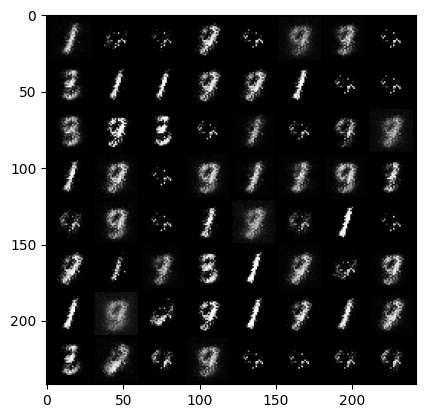

In [9]:
import matplotlib.pyplot as plt

# Generate and visualize some images
z = torch.randn(64, z_dim).to(device)
fake_images = G(z)
fake_images = fake_images.view(fake_images.size(0), 1, 28, 28)
fake_images = fake_images.cpu().data

grid = torchvision.utils.make_grid(fake_images, nrow=8, normalize=True)
plt.imshow(grid.permute(1, 2, 0))
plt.show()


In [10]:
torch.save(G.state_dict(), 'generator.pth')
torch.save(D.state_dict(), 'discriminator.pth')


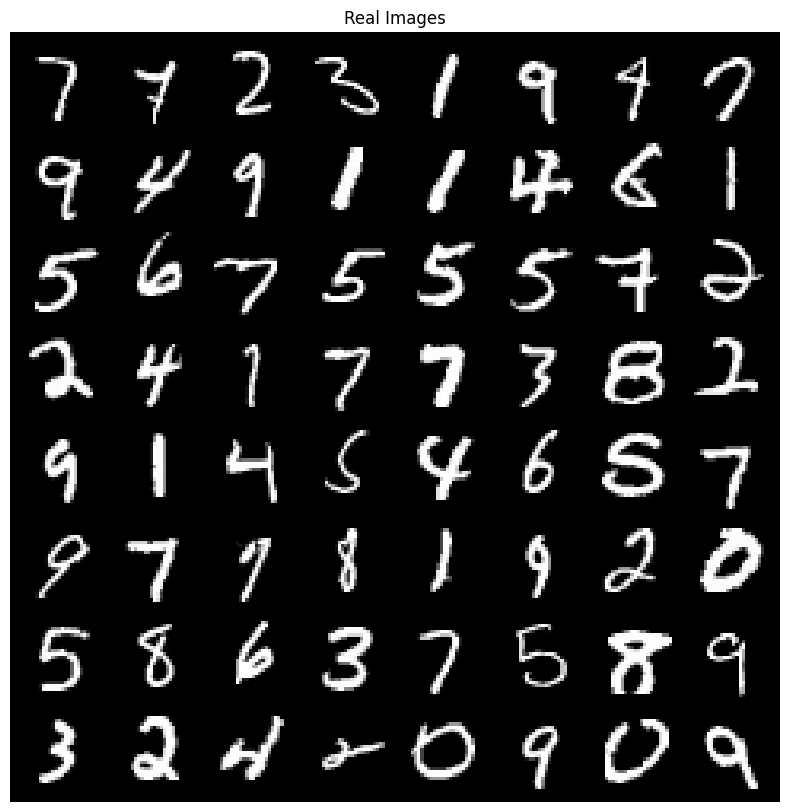

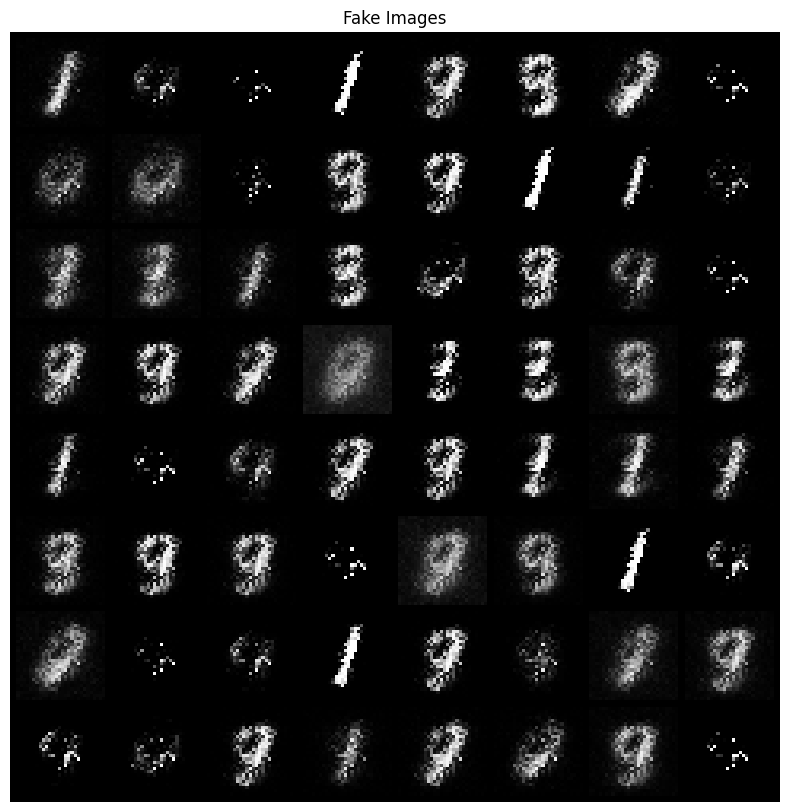

In [12]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

def show_images(real_images, fake_images, num_images=64):
    # Create a grid of real images
    real_images = real_images.view(real_images.size(0), 1, 28, 28)
    grid_real = vutils.make_grid(real_images[:num_images], nrow=8, normalize=True, padding=2)

    # Create a grid of fake images
    fake_images = fake_images.view(fake_images.size(0), 1, 28, 28)
    grid_fake = vutils.make_grid(fake_images[:num_images], nrow=8, normalize=True, padding=2)

    # Plot real images
    plt.figure(figsize=(10, 10))
    plt.title('Real Images')
    plt.imshow(grid_real.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')

    # Plot fake images
    plt.figure(figsize=(10, 10))
    plt.title('Fake Images')
    plt.imshow(grid_fake.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')

    plt.show()

# Sample code to generate fake images and retrieve real images
with torch.no_grad():
    # Generate fake images
    z = torch.randn(64, z_dim).to(device)  # Adjust batch size as needed
    fake_images = G(z).detach().cpu()

    # Retrieve real images
    real_images, _ = next(iter(train_loader))  # Get a batch of real images
    real_images = real_images[:64]  # Take only 64 images for comparison

# Display the images
show_images(real_images, fake_images)
